<a href="https://colab.research.google.com/github/yihan-zhou/fastai/blob/main/week4-class-notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs

In [ ]:
! pip install transformers
! pip install datasets
! pip install accelerate -U
! pip install transformers[torch]

In [2]:
from transformers import BertTokenizer, TrainingArguments,Trainer, AutoModelForSequenceClassification
from datasets import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
inputs = tokenizer("Hello, world!", return_tensors="pt")
tokenizer.tokenize("Hello, world!")

['hello', ',', 'world', '!']

In [25]:
def tok_func(x): return tokenizer(x["input"])

## Tokenize the training set

In [24]:
# training dataset
path = "train.csv"
df = pd.read_csv(path)[:36000]
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36000 non-null  object 
 1   anchor   36000 non-null  object 
 2   target   36000 non-null  object 
 3   context  36000 non-null  object 
 4   score    36000 non-null  float64
 5   input    36000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


In [ ]:
ds = Dataset.from_pandas(df) # use the datasets library from Hugging Face
# This method is particularly useful for tokenizing large datasets
# because it automatically handles the batching and multiprocessing
# aspects, leading to faster processing times.
tok_ds = ds.map(tok_func, batched=True)
row = tok_ds[0]
row['input'], row['input_ids']

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name labels, but in our dataset it's currently score. Therefore, we need to rename it:

In [27]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Transformers uses a DatasetDict for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use train_test_split:

In [28]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27000
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9000
    })
})

## Tokenize the evaluation set

Test set is only used for the final step. Validation set is used to tune the hyperparameters.

In [29]:
# Evaluation dataset
# df_eval = pd.read_csv("test.csv")
df_eval = pd.read_csv(path)[36000:]
df_eval['input'] = 'TEXT1: ' + df_eval.context + '; TEXT2: ' + df_eval.target + '; ANC1: ' + df_eval.anchor
eval_ds = Dataset.from_pandas(df_eval).map(tok_func, batched=True)
eval_ds = eval_ds.rename_columns({'score':'labels'})

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

In [30]:
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 473
})

In [31]:
df_eval.head()

,id,anchor,target,context,score,input
36000,f7fa7c8605c40a78,wearability,wear characteristics,B21,0.50,TEXT1: B21; TEXT2: wear characteristics; ANC1:...
36001,c8757b8201719536,wearability,wear life,B21,0.75,TEXT1: B21; TEXT2: wear life; ANC1: wearability
36002,c2aeb2bacfb272b1,wearability,wearability,B21,1.00,TEXT1: B21; TEXT2: wearability; ANC1: wearability
36003,217271e252282202,wearability,wearable gadgets,B21,0.00,TEXT1: B21; TEXT2: wearable gadgets; ANC1: wea...
36004,e9492b2f6cbafdef,web transfer,curved bars,B29,0.25,TEXT1: B29; TEXT2: curved bars; ANC1: web tran...


## Define the evaluation matrix

In [35]:
def corr(x,y):
  return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred):
  return {'pearson': corr(*eval_pred)}

## Train the model

In [32]:
bs = 128
epochs = 4
lr = 8e-5

In [33]:
args = TrainingArguments('outputs',
                         learning_rate=lr,
                         warmup_ratio=0.1,
                         lr_scheduler_type='cosine',
                         fp16=True,
                         evaluation_strategy="epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=bs*2,
                         num_train_epochs=epochs,
                         weight_decay=0.01,
                         report_to='none')

In [34]:
model_nm = 'microsoft/deberta-v3-small'

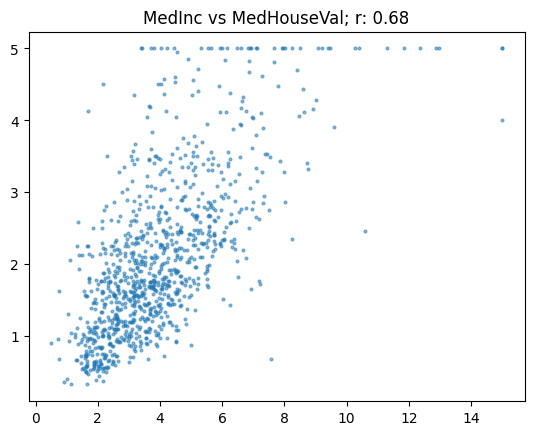

In [36]:
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing(as_frame=True)
# housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
# np.set_printoptions(precision=2, suppress=True)
# np.corrcoef(housing, rowvar=False)
# def show_corr(df, a, b):
#     x,y = df[a],df[b]
#     plt.scatter(x,y, alpha=0.5, s=4)
#     plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

# show_corr(housing, 'MedInc', 'MedHouseVal')

In [37]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

trainer = Trainer(model,
                  args=args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokenizer,
                  compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
trainer.train();

Step,Training Loss
500,0.068900
1000,0.059300
1500,0.058300
2000,0.056000
2500,0.053500
3000,0.051900
3500,0.051700
4000,0.049400
4500,0.047900
5000,0.047100


In [39]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
preds

array([0.42, 0.46, 1.  , 0.25, 0.22, 0.25, 0.25, 0.25, 0.11, 0.34, 0.6 ,
       0.27, 0.44, 0.54, 0.57, 0.19, 0.3 , 0.27, 0.33, 0.26, 0.2 , 0.17,
       0.24, 0.42, 0.39, 1.  , 0.75, 0.77, 0.39, 0.58, 1.  , 0.19, 0.41,
       1.  , 0.42, 0.13, 0.26, 0.19, 0.47, 0.2 , 0.21, 0.23, 0.24, 0.22,
       0.23, 0.29, 0.55, 0.2 , 0.29, 0.2 , 0.27, 0.13, 0.58, 0.69, 0.65,
       0.29, 0.27, 0.23, 0.49, 0.23, 0.26, 0.28, 0.33, 0.53, 0.3 , 0.26,
       0.28, 0.28, 0.51, 0.25, 0.28, 0.25, 0.56, 0.43, 0.51, 0.34, 0.58,
       0.44, 0.47, 0.28, 0.37, 0.33, 0.29, 0.5 , 0.25, 0.22, 0.28, 0.53,
       0.45, 0.31, 0.17, 0.49, 0.47, 0.28, 0.24, 0.28, 0.25, 0.33, 0.55,
       0.23, 1.  , 0.53, 0.29, 0.63, 0.26, 0.3 , 0.25, 0.54, 0.66, 0.58,
       0.47, 0.57, 0.4 , 0.57, 0.32, 0.62, 0.28, 0.61, 0.67, 0.36, 0.68,
       0.3 , 0.22, 0.23, 0.28, 0.32, 0.31, 0.25, 0.71, 0.61, 0.34, 0.24,
       0.23, 0.21, 0.37, 0.6 , 0.26, 0.21, 0.23, 0.22, 0.26, 0.19, 0.27,
       0.24, 0.43, 0.28, 0.36, 0.3 , 0.29, 0.23, 0.